### Import Libraries

In [26]:
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from sklearn.svm import SVC # SVM
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier # MLP Classifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer # Sentence Transformer
from sklearn.feature_extraction.text import CountVectorizer

### Read dataset

In [3]:
df = pd.read_csv('Dataset/implicit_hate_v1_stg2_posts.tsv', sep='\t')
df.head()

,post,implicit_class,extra_implicit_class
0,""" : jewish harvard professor noel ignatiev w...",white_grievance,NaN
1,rt : tune in today's jmt for my interview w /...,irony,NaN
2,: : hate posters ? you want hate buddy ? read ...,white_grievance,NaN
3,: hunt for white women : black racist serial k...,stereotypical,NaN
4,: looks like he was a fan of the islamic jew-h...,stereotypical,NaN


In [4]:
# Drop unnecessary columns
df_clean  = df.drop(['extra_implicit_class'], axis = 1)
df_clean.head()

,post,implicit_class
0,""" : jewish harvard professor noel ignatiev w...",white_grievance
1,rt : tune in today's jmt for my interview w /...,irony
2,: : hate posters ? you want hate buddy ? read ...,white_grievance
3,: hunt for white women : black racist serial k...,stereotypical
4,: looks like he was a fan of the islamic jew-h...,stereotypical


In [5]:
# Each class samples
print('No. of samples belonging to each class:\n')
print(df_clean['implicit_class'].value_counts())

No. of samples belonging to each class:

white_grievance    1538
incitement         1269
stereotypical      1133
inferiority         863
irony               797
threatening         666
other                80
Name: implicit_class, dtype: int64


In [6]:
# Checking data foo null values
print('\nSum of null values in each column:')
print(df_clean.isna().sum())


Sum of null values in each column:
post              0
implicit_class    0
dtype: int64


In [7]:
print(df_clean['post'][3])

: hunt for white women : black racist serial killer confesses to 41 murders


### Data Preprocessing

In [8]:
def preprocess(data):
    # Lowercase conversion
    data['post'] = data['post'].apply(
        lambda x: " ".join(x.lower() for x in x.split()))
    # Removal of special characters
    data['post']= data['post'].str.replace('[^\w\s]', ' ')
    # Removal of Digits & numbers
    data['post'] = data['post'].str.replace('\d+',' ')
    data['post'] = data['post'].str.replace('_',' ')
    # Removal of stopwords
    data['post'] = data['post'].apply( 
        lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english')))
    # Lemmatization
    data['post'] = [WordNetLemmatizer().lemmatize(word) for word in data['post']]
    
    return data

df_clean = preprocess(df_clean)

### Data Visualization

<AxesSubplot:xlabel='implicit_class', ylabel='count'>

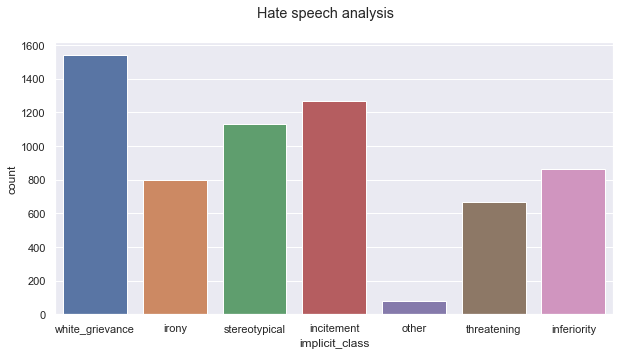

In [9]:
plt.figure(figsize=(10, 5))
sns.set()
plt.suptitle('Hate speech analysis')
sns.countplot(df_clean['implicit_class'])

In [10]:
# Data Encoding
df_clean['labels'] = LabelEncoder().fit_transform(df_clean['implicit_class'])

## Subtype Classification (BERT)

In [11]:
# Feature and target selection
x = df_clean['post']
y = df_clean['labels']

In [68]:
# Load pre-trained BERT model
model_name = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(model_name)

# Encode text using pre-trained BERT model
encoded_text = model.encode(x.tolist())

### Data Balancing

In [90]:
from imblearn.over_sampling import RandomOverSampler
# Define the undersampling method
oversampler = RandomOverSampler()
# # Undersample the data
x_sampled, y_sampled = oversampler.fit_resample(encoded_text, y)

print('\nNo. of samples before Balancing:\n')
print(y.value_counts())
# print('No. of samples(hate):', y.value_counts()[1])
print('\nAfter Balancing data----------------------------\n')
print(y_sampled.value_counts())


No. of samples before Balancing:

6    1538
0    1269
4    1133
1     863
2     797
5     666
3      80
Name: labels, dtype: int64

After Balancing data----------------------------

6    1538
2    1538
4    1538
0    1538
3    1538
5    1538
1    1538
Name: labels, dtype: int64


In [91]:
# Train-Test splitting
X_train, X_test, y_train, y_test = train_test_split(x_sampled, y_sampled, 
                                                    test_size=0.2, random_state=42)

Accuracy: 0.7804085422469823 

                 precision    recall  f1-score   support

     incitement       0.68      0.59      0.63       309
    inferiority       0.74      0.84      0.79       285
          irony       0.84      0.79      0.81       323
          other       0.99      1.00      1.00       300
  stereotypical       0.78      0.73      0.75       322
    threatening       0.82      0.87      0.85       310
white_grievance       0.62      0.64      0.63       305

       accuracy                           0.78      2154
      macro avg       0.78      0.78      0.78      2154
   weighted avg       0.78      0.78      0.78      2154



<AxesSubplot:>

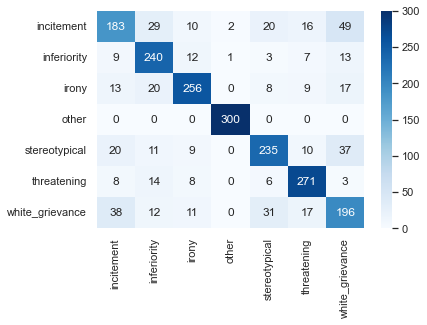

In [97]:
# Define MLP classifier with 6 output classes
classifier = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000)

# Train the classifier on the encoded text
classifier.fit(X_train, y_train)

# Predict the labels for the encoded text
y_pred = classifier.predict(X_test)

# Calculate accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy} \n")

# Calculate classification report and confusion matrix
classes = ['incitement', 'inferiority', 'irony', 'other', 'stereotypical', 'threatening', 'white_grievance']
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='d')

# Multiclass Classification (CountVectorizer)

In [20]:
vectorizer = CountVectorizer(max_features=1000) 
x = vectorizer.fit_transform(df_clean['post']).toarray()

In [21]:
y = df_clean['labels']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, random_state=42)

### Deep Neural Network + Random Forest Classifier

In [27]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_shape=(1000,),activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dropout(0.5))

x_train_1 = model.predict(x_train)
x_test_1 = model.predict(x_test)

# Random Forest
clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
clf = clf.fit(x_train_1, y_train)
rf_pred = clf.predict(x_test_1)
print('\033[47m' + 'Classification Report\n\n' + '\033[0m' + '\033[34m', classification_report(y_test, rf_pred))

40/40 [==============================] - 0s 8ms/step
Classification Report

               precision    recall  f1-score   support

           0       0.27      0.23      0.25       253
           1       0.17      0.08      0.11       167
           2       0.23      0.14      0.17       169
           3       0.00      0.00      0.00        17
           4       0.16      0.12      0.14       219
           5       0.12      0.03      0.05       120
           6       0.28      0.58      0.38       325

    accuracy                           0.25      1270
   macro avg       0.18      0.17      0.16      1270
weighted avg       0.22      0.25      0.21      1270



### Deep Neural Network + Support Vector Classifier

In [28]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_shape=(1000,),activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dropout(0.5))

x_train_2 = model.predict(x_train)
x_test_2 = model.predict(x_test)

# SVM
svc_model = SVC()
svc_model.fit(x_train_2, y_train)
svc_pred = svc_model.predict(x_test_2)
print('\033[47m' + 'Classification Report\n\n' + '\033[0m' + '\033[32m', classification_report(y_test, svc_pred))

40/40 [==============================] - 0s 6ms/step
Classification Report

               precision    recall  f1-score   support

           0       0.30      0.35      0.32       253
           1       0.16      0.06      0.09       167
           2       0.26      0.21      0.23       169
           3       0.00      0.00      0.00        17
           4       0.32      0.32      0.32       219
           5       0.19      0.11      0.14       120
           6       0.40      0.59      0.47       325

    accuracy                           0.32      1270
   macro avg       0.23      0.23      0.22      1270
weighted avg       0.29      0.32      0.30      1270

